## Short training example
This notebook shows the general capability of training a GNN model on dataset020. The datasets are automatically downlaoded from Zenodo and the model is trained using one seed on the first 1,000 synthetic grids. To obtain the results from the paper, larger models need to be trained.

Before executing the script, a conda environment should be generated using the conda_env.yml from GitHub.

This script requires the file gnn_models.py in the same directory.

In [31]:
import wget
import os
import zipfile

from pathlib import Path

from gnn_models import GNNmodule, gnn_snbs_surv
from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt

##########
# download and unzip datasets
def automatically_download_datasets(path_for_datasets):
    zenodo_url = 'https://zenodo.org/record/8204334/files/'
    dataset020_url = zenodo_url + 'ds20.zip'
    dataset100_url = zenodo_url + 'ds100.zip'

    if os.path.isdir(path_for_datasets)==False:
        os.mkdir(path_for_datasets)

    dataset020_zip = path_for_datasets + '/ds20.zip'
    dataset100_zip = path_for_datasets + '/ds100.zip'

    if os.path.isfile(dataset020_zip) == False:
        wget.download(dataset020_url,"downloaded_datasets/ds20.zip")
        
    if os.path.isfile(dataset100_zip) == False:
        wget.download(dataset100_url,"downloaded_datasets/ds100.zip")


def unzip_datasets(path_for_datasets):
    dataset020_zip = path_for_datasets + '/ds20.zip'
    dataset100_zip = path_for_datasets + '/ds100.zip'
    with zipfile.ZipFile(dataset020_zip, 'r') as zip_ref:
        zip_ref.extractall(path_for_datasets)
    with zipfile.ZipFile(dataset100_zip, 'r') as zip_ref:
        zip_ref.extractall(path_for_datasets)

# The datasets will be downloaded and stored in path_for_datasets, change if desired.
path_for_datasets = 'downloaded_datasets'
automatically_download_datasets(path_for_datasets) ## in case of manual download, put the zip files in path_for_dataset and remove this line

unzip_datasets(path_for_datasets)
########


result_path= Path("training_run_directory")
if os.path.isdir(result_path)==False:
    os.mkdir(result_path)


# config for training
cfg = {}
# dataset
cfg["dataset::path"] = Path(path_for_datasets + '/ds20')
cfg["task"] = "snbs"
cfg["task_type"] = "regression"

# dataset batch sizes
cfg["train_set::batchsize"] = 228

cfg["test_set::batchsize"] = 500
cfg["valid_set::batchsize"] = 500
cfg["train_set::shuffle"] = True
cfg["test_set::shuffle"] = False
cfg["valid_set::shuffle"] = False


# model settings
cfg["model_name"] = "TAGNet_ray"
cfg["final_linear_layer"] = False
cfg["num_layers"] = 3
cfg["num_channels1"] = 1
cfg["num_channels2"] = 20 
cfg["num_channels3"] = 20
cfg["num_channels4"] = 1

cfg["batch_norm_index"] = [True, True, True]
cfg["activation"] = ["relu","relu","None"]

#TAG
cfg["TAG::K_hops1"] = 3
cfg["TAG::K_hops2"] = 3
cfg["TAG::K_hops3"] = 3

# training settings
cfg["cuda"] = True
cfg["manual_seed"] = 1
# cfg["epochs"] = 1500
cfg["epochs"] = 400
cfg["optim::optimizer"] = "SGD"
cfg["optim::LR"] = 3.0

cfg["optim::momentum"] = .9
cfg["optim::weight_decay"] = 1e-9
cfg["optim::scheduler"] = None
cfg["criterion"] = "MSELoss"
# evaluation
cfg["eval::threshold"] = .1

# initialize model
gnnmodule = GNNmodule(cfg)


# init datasets and dataloader
train_set = gnn_snbs_surv(cfg["dataset::path"] / 'train',cfg["task"], cfg["task_type"], slice_index=slice(0,1000)) # training uses only the first 1,000 grids
valid_set = gnn_snbs_surv(cfg["dataset::path"] / 'valid', cfg["task"], cfg["task_type"], slice_index=slice(7000,8499))
test_set = gnn_snbs_surv(cfg["dataset::path"] / 'test', cfg["task"], cfg["task_type"], slice_index= slice(8500,9999))

train_loader = DataLoader(
    train_set, batch_size=cfg["train_set::batchsize"], shuffle=cfg["train_set::shuffle"])
valid_loader = DataLoader(
    train_set, batch_size=cfg["valid_set::batchsize"], shuffle=cfg["valid_set::shuffle"])
test_loader = DataLoader(
    test_set, batch_size=cfg["test_set::batchsize"], shuffle=cfg["test_set::shuffle"])

train_loss_all_epochs = []
train_accu_all_epochs = []
train_R2_all_epochs = []

test_loss_all_epochs = []
test_accu_all_epochs = []
test_R2_all_epochs = []

epochs = cfg["epochs"]
for epoch in range(1,epochs):
    print(f"Epoch {epoch}/{epochs}.. ")
    train_loss, train_accu, train_R2 = gnnmodule.train_epoch_regression(train_loader, cfg["eval::threshold"])
    train_loss_all_epochs.append(train_loss)
    train_accu_all_epochs.append(train_accu)
    train_R2_all_epochs.append(train_R2)
    test_loss, test_accu, test_R2 = gnnmodule.eval_model_regression(test_loader, cfg["eval::threshold"])
    test_loss_all_epochs.append(test_loss)
    test_accu_all_epochs.append(test_accu)
    test_R2_all_epochs.append(test_R2)
    print('train R2: ''{:3.2f}'.format(100 * train_R2) + '%')
    print('train accu: ''{:3.2f}'.format(train_accu) + '%')
    print('test R2: ''{:3.2f}'.format(100 * test_R2) + '%')
    print('test accu: ''{:3.2f}'.format(test_accu) + '%')
print("finished")

cuda unavailable:: train model on cpu
information to final sigmoid layer missing, setting it to True
Epoch 1/400.. 
train R2: -513.72%
train accu: 40.04%
test R2: -127.18%
test accu: 35.90%
Epoch 2/400.. 
train R2: -164.98%
train accu: 32.28%
test R2: -186.83%
test accu: 30.45%
Epoch 3/400.. 
train R2: -203.78%
train accu: 28.68%
test R2: -261.51%
test accu: 28.64%
Epoch 4/400.. 
train R2: -200.69%
train accu: 28.82%
test R2: -390.03%
test accu: 26.95%
Epoch 5/400.. 
train R2: -198.92%
train accu: 29.22%
test R2: -206.96%
test accu: 28.67%
Epoch 6/400.. 
train R2: -192.94%
train accu: 29.67%
test R2: -199.88%
test accu: 29.26%
Epoch 7/400.. 
train R2: -183.59%
train accu: 30.89%
test R2: -191.63%
test accu: 29.89%
Epoch 8/400.. 
train R2: -169.82%
train accu: 33.59%
test R2: -200.75%
test accu: 28.13%
Epoch 9/400.. 
train R2: -152.19%
train accu: 38.65%
test R2: -197.50%
test accu: 28.22%
Epoch 10/400.. 
train R2: -139.71%
train accu: 42.36%
test R2: -194.07%
test accu: 28.57%
Epoch 11

At the beginning R2, is very low, hence the limits of the axis can be set if desired. The default settings are to start plotting after the first 8 epochs.

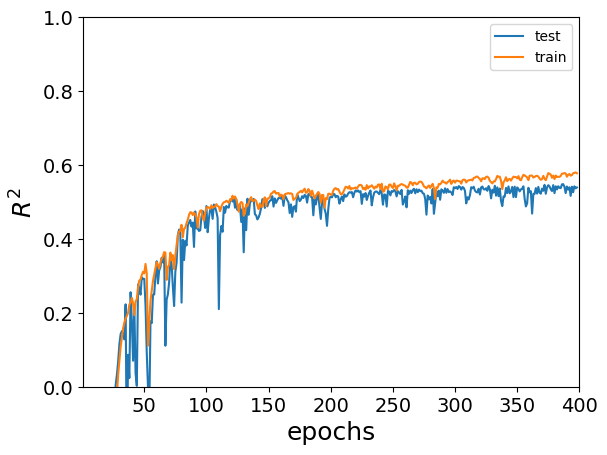

In [33]:
fig, ax = plt.subplots(1,1)
ax.plot(test_R2_all_epochs, label="test")
ax.plot(train_R2_all_epochs, label="train")
ax.set_ylabel('$R^2$',fontsize=18)
ax.set_xlabel('epochs',fontsize=18)
ax.set_xlim([1,epochs])
# ax.set_xlim=[5,8]
# ax.set_ylim=[0,1]
ax.set_ylim([0,1])
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend()
plt.show()